**Course**:    Social graphs and interactions

**No.**:       02805

**Students**:  s204255 & s204122

**Date**:      11th December 2024



# Imports

In [4]:
import requests
import json
from bs4 import BeautifulSoup
import networkx as nx
import re
from matplotlib import pyplot as plt
import time
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Load statics

In [5]:
# Load stored course-site HTMLs
with open('valid_courses.json') as f:
    valid_courses = json.load(f)

# Load department color mapping
with open('department_colors.json') as f:
    department_colors = json.load(f)

# Load department names
with open('department_names.json') as f:
    department_names = json.load(f)

# Create graph

## Add nodes

In [6]:
# Initialize directd graph
G = nx.DiGraph()

# Go through each course
for course_num in valid_courses:
    department = course_num[:2] 
    G.add_node(course_num,
               course_num=course_num,
               page=valid_courses[course_num],
               department=department, 
               color=department_colors[department],
               department_name=department_names[department])

## Add edges

In [7]:
for course_num in valid_courses:

    # Initialize BeautifulSoup object
    page = G.nodes[course_num]['page']
    soup = BeautifulSoup(page, 'html.parser')

    # Define the search pattern to match both "Academic prerequisites" and "Mandatory prerequisites"
    search_pattern = r"(Academic prerequisites|Mandatory Prerequisites)"
    
    # Find the label element that matches the pattern
    label = soup.find('label', string=re.compile(search_pattern))
    if label is None:
        continue  # Skip if no label is found
    
    # Get the parent element that contains the label and prerequisites
    parent = label.find_parent().find_parent()
    
    # Get the second <td> (assuming it contains the prerequisites text)
    prerequisite = parent.find_all('td')[1].text

    # Remove whitespace and line breaks
    prerequisite = prerequisite.replace('\r', ' ').replace('\n', ' ')

    # Extract 5-digit course numbers
    prerequisites = set(re.findall(r'\d{5}', prerequisite))
    
    # Add edges to the graph for valid prerequisites
    for prerequisite in prerequisites:
        if prerequisite in G.nodes:
            if prerequisite != course_num:  # Skip self-loops
                G.add_edge(prerequisite, course_num)


## Add text attributes

In [8]:
for node in G.nodes:
    
    ### Initialize BeuatifulSoup object
    page = G.nodes[node]['page']
    soup = BeautifulSoup(page, 'html.parser')
    
    ### Add title to node
    title = soup.title.text
    cleaned = ' '.join(title.strip().split())[6:]
    G.nodes[node]['course_title'] = cleaned
    
    ### Add course text to node (General course objectives + Learning objectives + Content)
    div = soup.find('div', string=re.compile("General course objectives")).parent(string=True)
    
    remove_indeces = []
    for d, text in enumerate(div):
        if text in ["General course objectives", "Learning objectives", "Content", "Last updated", "\r\nA student who has met the objectives of the course will be able to:\r\n\r\n"]:
            remove_indeces.append(d)
    
    new_div = [div[i] for i in range(len(div)) if i not in remove_indeces]
    text = ' '.join(new_div[:-1]).replace('\r', ' ').replace('\n', '')
    cleaned = ' '.join(text.strip().split())
    G.nodes[node]['course_text'] = cleaned  
    G.nodes[node]['text_size'] = len(cleaned) 
    G.nodes[node]['word_count'] = len(cleaned.split())

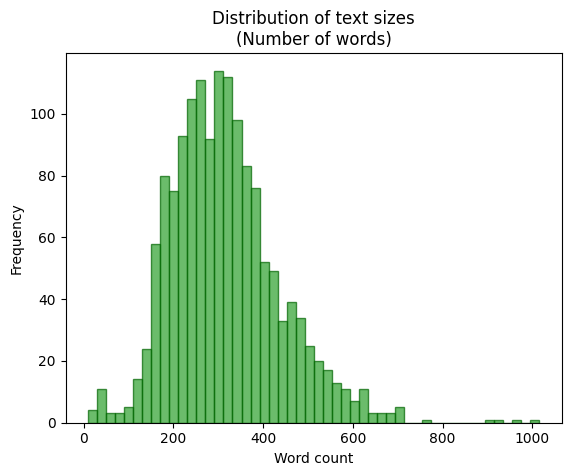

In [9]:
# plot distribution of text sizes
text_sizes = [G.nodes[node]['word_count'] for node in G.nodes]
plt.hist(text_sizes, bins=50, color='C2', alpha=0.7, edgecolor='darkgreen')
plt.title('Distribution of text sizes\n(Number of words)')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()

# Get evaluations and grades

In [10]:
# Evaluations
with open('eval_scores.json') as f:
    eval_scores = json.load(f)

# Grades
with open('grade_scores.json') as f:
    grade_scores = json.load(f)

In [11]:
# Apply evaluation and grade attributes
for course_num in grade_scores:
    G.nodes[course_num]['eval_scores'] = eval_scores[course_num]
    G.nodes[course_num]['grade_scores'] = grade_scores[course_num]
    
# Remove nodes from G that do not have evaluation scores
G = G.subgraph([node for node in G.nodes if 'eval_scores' in G.nodes[node]])
# Remove nodes from G with empty evaluation scores
G = G.subgraph([node for node in G.nodes if G.nodes[node]['eval_scores']])

In [12]:
G.nodes['02805']

{'course_num': '02805',
 'page': '<!DOCTYPE html>\r\n<html>\r\n<head>\r\n    <meta http-equiv="X-UA-Compatible" content="IE=edge" />\r\n    <meta charset="utf-8" />\r\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\r\n    \r\n    <title>\r\n    02805 Social graphs and interactions \r\n</title>\r\n    <link href="/bundles_css_general?v=mCt0xLH6ZVm097AMT4IZXI_8YhGCBjBIv-CzzPZWduw1" rel="stylesheet"/>\r\n\r\n    <script src="/bundles_js_general?v=m944kgjFG7-r2HFwxi7Q_xDuvGXt8MWkcxYxVH_TSmE1"></script>\r\n\r\n    \r\n\r\n\r\n    <script>\r\n        $(function () {\r\n            $("[data-open-dialog]").on(\'click touchstart\', function () {\r\n                var me = $(this);\r\n                var bs = $("#" + me.data("open-dialog"));\r\n                bs.modal({ show: true, backdrop: true });\r\n            });\r\n        });\r\n\r\n        function getCookie(cname) {\r\n            var name = cname + "=";\r\n            var decodedCookie = decodeURIComponen

# Degree distribution

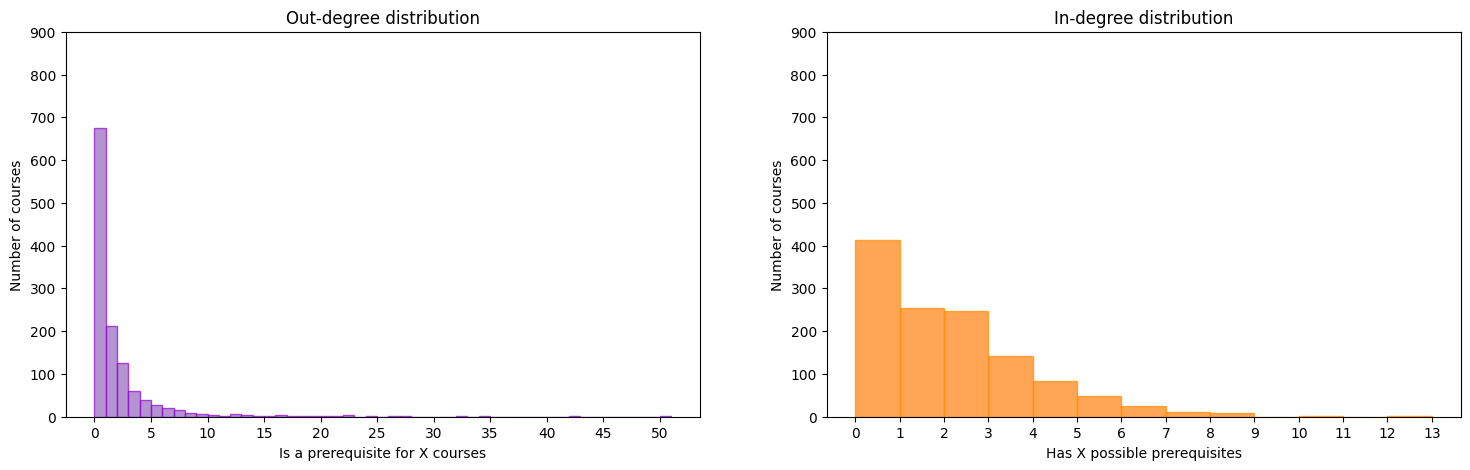

In [17]:
# Calculate in- and out-degrees. Show histogram
in_degrees = [G.in_degree(n) for n in G.nodes]
out_degrees = [G.out_degree(n) for n in G.nodes]

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
axs[0].set_ylim(0, 900)
axs[0].hist(out_degrees, bins=range(min(out_degrees), max(out_degrees) + 2), color='C4', alpha=0.7, edgecolor='darkviolet')
axs[0].set_xlabel('Is a prerequisite for X courses')
axs[0].set_ylabel('Number of courses')
axs[0].set_title('Out-degree distribution')
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[0].xaxis.set_major_locator(plt.MultipleLocator(5))

axs[1].set_ylim(0, 900)
axs[1].hist(in_degrees, bins=range(min(in_degrees), max(in_degrees) + 2), color='C1', alpha=0.7, edgecolor='darkorange')

axs[1].set_xlabel('Has X possible prerequisites')
axs[1].set_ylabel('Number of courses')
axs[1].set_title('In-degree distribution')
axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[1].xaxis.set_major_locator(plt.MultipleLocator(1))

plt.show()

# Plotting

## Test partitionings

In [18]:
import networkx as nx
from collections import Counter, defaultdict
import random

def overlapping_label_propagation(graph, max_size, max_iterations=100):
    """
    Overlapping Label Propagation Algorithm with size constraints.

    Parameters:
        graph (nx.Graph): The input graph.
        max_size (int): The maximum allowable size for a community.
        max_iterations (int): Maximum number of iterations to run the algorithm.

    Returns:
        dict: A dictionary where keys are community indices (starting from 0) and values are lists of nodes.
    """
    # Initialize each node with its own unique label as a set
    labels = {node: {node} for node in graph.nodes}
    
    for iteration in range(max_iterations):
        changes = False
        
        # Randomize node order to reduce bias
        nodes = list(graph.nodes)
        random.shuffle(nodes)
        
        for node in nodes:
            # Collect all labels from neighbors
            neighbor_labels = []
            for neighbor in graph.neighbors(node):
                neighbor_labels.extend(labels[neighbor])  # Collect labels of neighbors
            
            # Count the frequency of each label in the neighborhood
            label_counts = Counter(neighbor_labels)
            
            # Sort labels by frequency (descending) and resolve ties randomly
            sorted_labels = sorted(label_counts.items(), key=lambda x: (-x[1], random.random()))
            
            # Add labels while respecting size constraints
            current_labels = labels[node]
            for label, _ in sorted_labels:
                community_size = sum(1 for n in graph.nodes if label in labels[n])
                if community_size < max_size and label not in current_labels:
                    current_labels.add(label)
                    changes = True
            
        # Stop if no labels were changed
        if not changes:
            break
    
    # Create a community dictionary with sequential indices
    community_dict = defaultdict(list)
    label_to_index = {}  # Map original labels to indices
    current_index = 0
    
    for node, node_labels in labels.items():
        for label in node_labels:
            if label not in label_to_index:
                label_to_index[label] = current_index
                current_index += 1
            community_dict[label_to_index[label]].append(node)
    
    return dict(community_dict)



In [19]:
def heuristic_pm_2(graph):
    '''
    For each node, add a community that consists of:
    1. The node itself
    2. Predecessors and the predecessors of predecessors
    3. Successors and the successors of successors 
    '''
    communities = defaultdict(list)  # Store communities indexed by node
    
    for node in graph.nodes:
        # Initialize the community with the node itself
        community = set([node])
        
        # Add predecessors and their predecessors
        for pred in graph.predecessors(node):
            community.add(pred)
            community.update(graph.predecessors(pred))
        
        # Add successors and their successors
        for succ in graph.successors(node):
            community.add(succ)
            community.update(graph.successors(succ))
        
        # Convert the community set to a list and assign it
        communities[node] = list(community)
    
    # remove communities with more than 15 courses
    communities = {k: v for k, v in communities.items() if len(v) <= 15}
    unique_courses = set()
    for community in communities.values():
        unique_courses.update(community)
    
    # replace nodes with indeces
    # replace nodes with indeces
    _communities = {}
    for i, key in enumerate(communities.keys()):
        _communities[i] = communities[key].copy()

    return dict(_communities)


def heuristic_pm_1(graph):
    '''
    For each node, add a community that consists of:
    1. The node itself
    2. Immediate predecessors
    3. Immediate successors
    '''
    communities = defaultdict(list)  # Store communities indexed by node
    
    for node in graph.nodes:
        # Initialize the community with the node itself
        community = set([node])
        
        # Add immediate predecessors
        community.update(graph.predecessors(node))
        
        # Add immediate successors
        community.update(graph.successors(node))
        
        # Convert the community set to a list and assign it
        communities[node] = list(community)
    
    # remove communities with more than 9 courses
    communities = {k: v for k, v in communities.items() if len(v) <= 9}
    unique_courses = set()
    for community in communities.values():
        unique_courses.update(community)

    # replace nodes with indeces
    _communities = {}
    for i, key in enumerate(communities.keys()):
        _communities[i] = communities[key].copy()

    return dict(_communities)


In [20]:
# Method 1 - Ordinary label propagation
from networkx.algorithms.community import label_propagation_communities
H = G.to_undirected()
communities = label_propagation_communities(H)

In [21]:
# Method 2 - Overlapping label propagation with size constraints
H = G.to_undirected()
communities = overlapping_label_propagation(H, 6)

In [22]:
# Method 3 - Overlapping label propagation with size constraints and degree filtering
H = G.to_undirected()
for node in G.nodes:
    if G.out_degree(node) > 10:
        H.remove_node(node)  
communities = overlapping_label_propagation(H, 6)

In [23]:
# Method 4 - Heuristic ± 1 (directed graph with constraints)
H = G.copy()
communities = heuristic_pm_1(H)

In [24]:
# Method 5 - Heuristic ± 2 (directed graph with constraints)
H = G.copy()
communities = heuristic_pm_2(H)

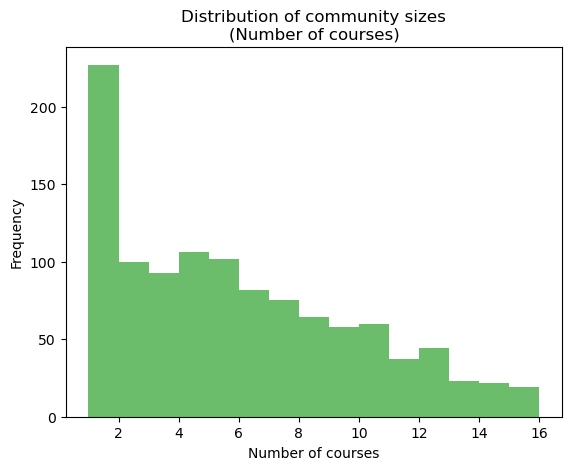

In [18]:
# plot distribution of value sizes
value_sizes = [len(communities[c]) for c in communities]
plt.hist(value_sizes, bins=range(min(value_sizes), max(value_sizes) + 2), color='C2', alpha=0.7)
plt.title('Distribution of community sizes\n(Number of courses)')
plt.xlabel('Number of courses')
plt.ylabel('Frequency')
plt.show()

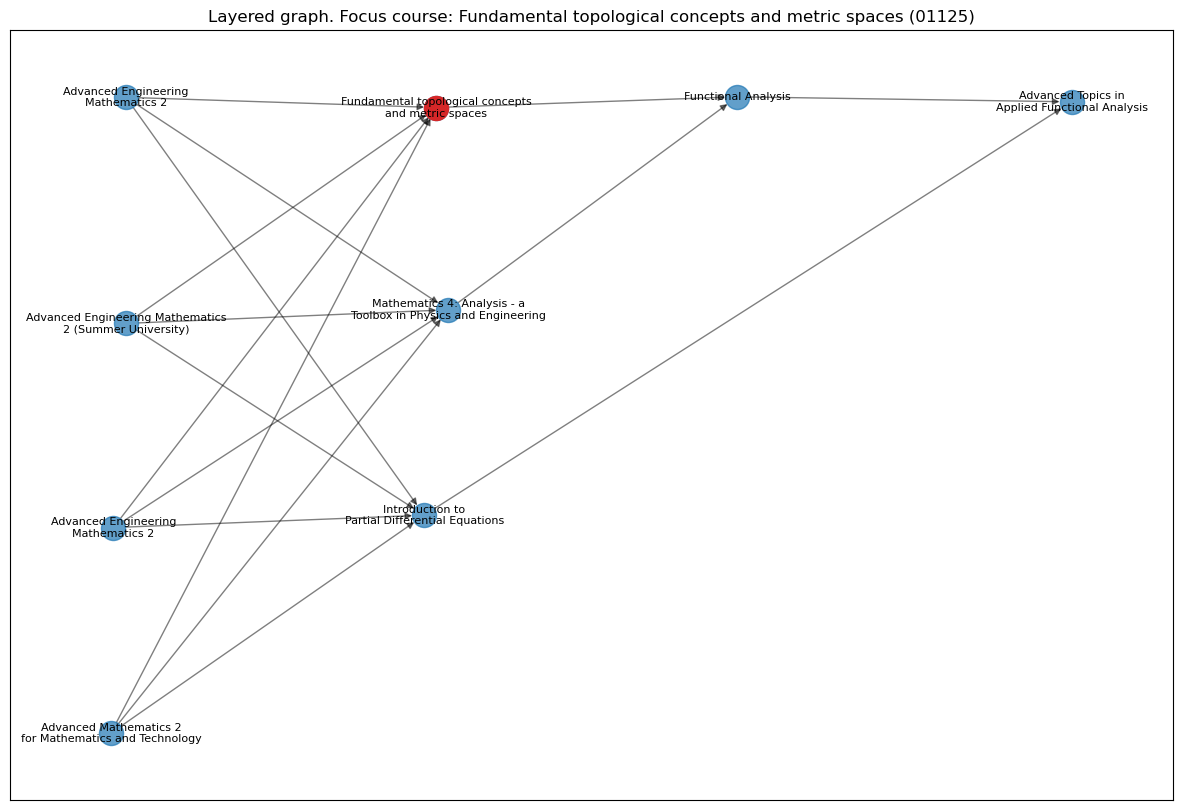

In [31]:
def plot_depth_based_layered_graph(community, graph):
    """
    Plot a layered graph where nodes are placed in layers based on depth
    from the root nodes in the directed subgraph.
    Dynamically reassigns nodes to fix layering violations.
    """
    # Create a directed subgraph from the community
    subgraph = graph.subgraph(community)
    
    # Ensure all community nodes are in the subgraph
    subgraph_nodes = set(subgraph.nodes)
    community = [node for node in community if node in subgraph_nodes]
    
    # Identify root nodes (nodes with in-degree 0)
    roots = [node for node in community if subgraph.in_degree(node) == 0]
    
    # Initialize layers, visited set, and node-to-layer mapping
    layers = defaultdict(list)
    node_to_layer = {}
    visited = set()
    
    # Assign layers iteratively
    def assign_layer(node, current_layer):
        # If the node is already visited, reassign it to a deeper layer if needed
        if node in visited:
            existing_layer = node_to_layer[node]
            if existing_layer < current_layer:
                # Move the node to the current deeper layer
                if node in layers[existing_layer]:
                    layers[existing_layer].remove(node)
                layers[current_layer].append(node)
                node_to_layer[node] = current_layer
            return
        
        # Add the node to the current layer
        layers[current_layer].append(node)
        node_to_layer[node] = current_layer
        visited.add(node)
        
        # Process successors
        for successor in subgraph.successors(node):
            assign_layer(successor, current_layer + 1)
    
    # Assign layers starting from each root
    for root in roots:
        assign_layer(root, 0)
    
    # Ensure layering is consistent by reprocessing predecessors
    for node in community:
        # Skip nodes not yet assigned a layer
        if node not in node_to_layer:
            continue
        
        node_layer = node_to_layer[node]
        for predecessor in subgraph.predecessors(node):
            predecessor_layer = node_to_layer.get(predecessor, -1)
            if predecessor_layer >= node_layer:
                # Move the node to a deeper layer
                if node in layers[node_layer]:
                    layers[node_layer].remove(node)
                new_layer = predecessor_layer + 1
                layers[new_layer].append(node)
                node_to_layer[node] = new_layer
    
    # Assign positions for all nodes in the subgraph
    pos = {}
    for i, (layer, nodes) in enumerate(sorted(layers.items())):
        for j, node in enumerate(nodes):
            pos[node] = (i+np.random.rand()/10, -j+np.random.rand()/10)
    
    # Check for unpositioned nodes and add them to a separate layer
    unpositioned_nodes = [node for node in subgraph.nodes if node not in pos]
    if unpositioned_nodes:
        last_layer = max(pos.values(), default=(0, 0))[0] + 1
        for j, node in enumerate(unpositioned_nodes):
            pos[node] = (last_layer, -j)
    
    # Determine the center node based on degree
    center_node = max(subgraph.nodes, key=lambda x: subgraph.degree(x))
    
    # Draw the graph
    # plt.figure(figsize=(25, 20))
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(subgraph, pos, node_size=300, node_color='C0', alpha=0.7)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.5)

    labels = {}
    for node in subgraph.nodes:
        label = graph.nodes[node].get('course_title', str(node))
        if len(label) > 20:
            split = label.split(' ')
            mid = len(split) // 2
            labels[node] = ' '.join(split[:mid]) + '\n' + ' '.join(split[mid:])
        else:
            labels[node] = label
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)
    
    # Highlight the center node in red
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[center_node], node_size=300, node_color='C3')
    
    plt.title(f"Layered graph. Focus course: {graph.nodes[center_node].get('course_title', str(center_node))} ({center_node})")
    plt.show()

plot_depth_based_layered_graph(communities[16], G)

### Department only

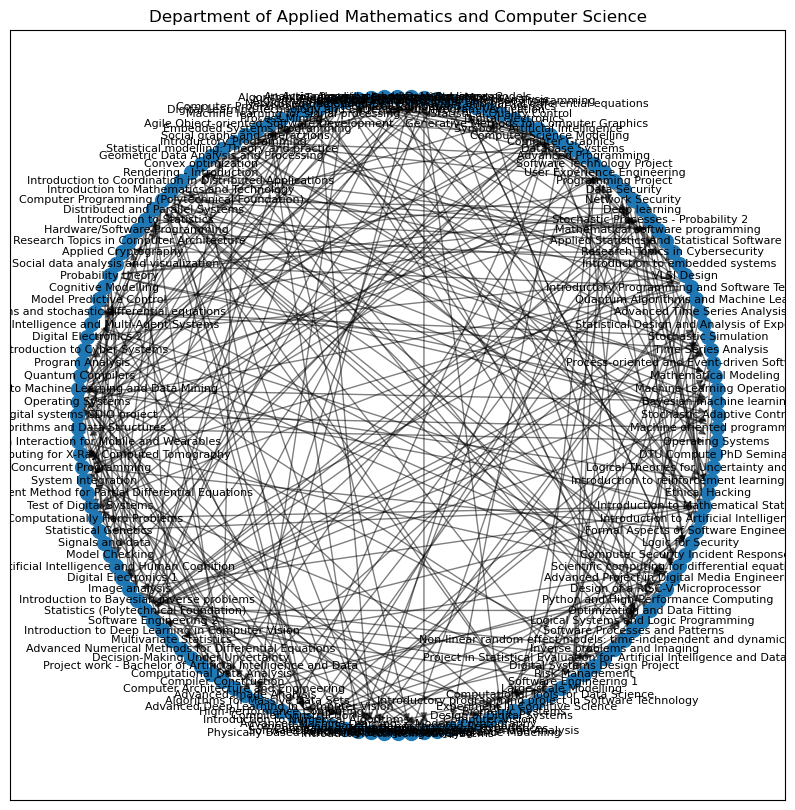

In [20]:
# plot subgraph of G, where department is X
department = '02'
subgraph = G.subgraph([node for node in G.nodes if G.nodes[node]['department'] == department])
pos = nx.circular_layout(subgraph)
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color=department_colors[department])
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
# labels = course_title
nx.draw_networkx_labels(subgraph, pos, labels={node: G.nodes[node]['course_title'] for node in subgraph.nodes}, font_size=8)
plt.title(department_names[department])
plt.show()

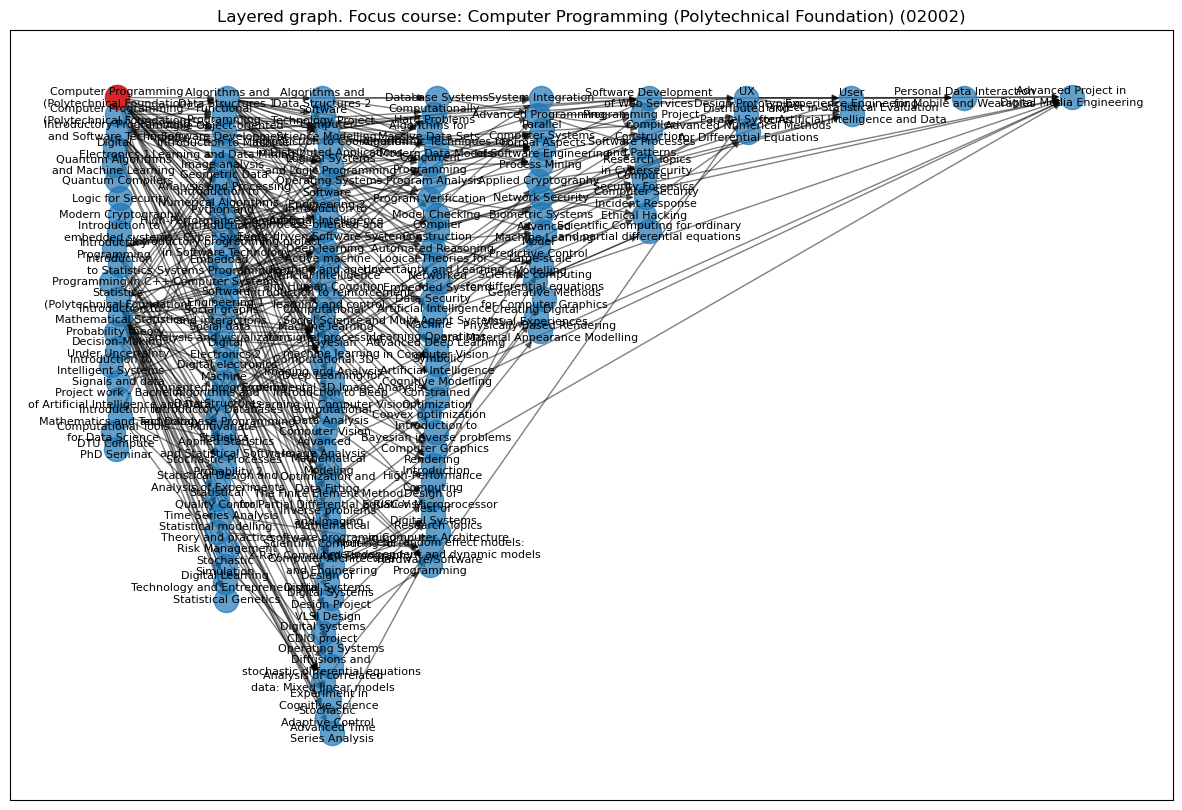

In [21]:
# get all courses from department
department = '02'
courses = [node for node in G.nodes if G.nodes[node]['department'] == department]

plot_depth_based_layered_graph(courses, G)

# Summarize communities

In [22]:
class CommunitiesSummary():
    def __init__(self, graph, communities):
        self.graph = graph
        self.communities = communities
    
    # Number of communities
    def __len__(self):
        return len(self.communities)
    
    # Average grade
    def avg_grade(self, community_index):
        grades = []
        for course in self.communities[community_index]:
            grade = self.graph.nodes[course]['grade_scores'][2]
            
            # Only add if the course uses the 7-scale grading system
            if grade is not None:
                grades.append(grade)
        
        # Return None if no grades were found
        if len(grades) == 0:
            return None
        
        # Return the average grade
        return sum(grades) / len(grades)
    
    # Average pass rate
    def avg_pass_rate(self, community_index):
        pass_rates = []
        for course in self.communities[community_index]:
            grade_scores = self.graph.nodes[course]['grade_scores']
            pass_rates.append(grade_scores[1] / grade_scores[0])
       
        # Return average pass rate 
        return sum(pass_rates) / len(pass_rates)
    
    # Average evaluation score
    def avg_evals(self, community_index):
        
        all_evals = []
        for i in range(6):
            evals = []
            for course in self.communities[community_index]:
                eval_score = self.graph.nodes[course]['eval_scores'][i]
                evals.append(eval_score)
            all_evals.append(sum(evals)/len(evals))
        
        return all_evals
    
    # Get single community stats
    def __getitem__(self, index):
        community = self.communities[index]
        return {
            'index': index,
            'size': len(community),
            'courses': community,
            'courses_titles': [self.graph.nodes[course]['course_title'] for course in community],
            'avg_grade': self.avg_grade(index),
            'avg_pass_rate': self.avg_pass_rate(index),
            'avg_evals': self.avg_evals(index),
            'all_text': ' '.join([self.graph.nodes[course]['course_text'] for course in community])
        }
        
    # Get all communities that includes course
    def get_communities(self, course):
        return [index for index, community in self.communities.items() if course in community]
   
        
COM = CommunitiesSummary(G, communities)

In [30]:
includes_course = COM.get_communities('01125')
print("Size:", len(includes_course))
for i in includes_course:
    display(COM[i])
    print()

Size: 6


{'index': 0,
 'size': 12,
 'courses': ['01715',
  '34251',
  '01405',
  '01003',
  '01018',
  '01125',
  '01017',
  '01001',
  '01415',
  '01019',
  '01621',
  '01238'],
 'courses_titles': ['Functional Analysis',
  'Advanced forward error correction and iterative decoding',
  'Algebraic Error-Correcting Codes',
  'Mathematics 1a (Polytechnical foundation)',
  'Discrete mathematics 2: algebra',
  'Fundamental topological concepts and metric spaces',
  'Discrete Mathematics',
  'Mathematics 1a (Polytechnical foundation)',
  'Computational Discrete Mathematics',
  'Discrete Mathematics',
  'Advanced Dynamical Systems: Global Theory',
  'Differential Geometry'],
 'avg_grade': 8.266666666666666,
 'avg_pass_rate': 0.9163151593545318,
 'avg_evals': [4.478594773469184,
  4.68199071161968,
  4.118603727188195,
  4.425195109931434,
  4.3569431738301505,
  3.3499581715718443],
 'all_text': "Many advanced mathematical disciplines, e.g., Fourier analysis, numerical analysis, the calculus of variati

{'index': 3,
 'size': 12,
 'courses': ['01034',
  '01004',
  '01018',
  '01037',
  '01125',
  '01237',
  '01920',
  '01035',
  '01002',
  '01020',
  '01238',
  '01025'],
 'courses_titles': ['Advanced Engineering Mathematics 2',
  'Mathematics 1b (Polytechnical Foundation)',
  'Discrete mathematics 2: algebra',
  'Advanced Engineering Mathematics 2 (Summer University)',
  'Fundamental topological concepts and metric spaces',
  'Differential geometry and parametric design',
  'Calculus and Algebra 2',
  'Advanced Engineering Mathematics 2',
  'Mathematics 1b (Polytechnical Foundation)',
  'Advanced Linear Algebra',
  'Differential Geometry',
  'Advanced Mathematics 2 for Mathematics and Technology'],
 'avg_grade': 7.172727272727272,
 'avg_pass_rate': 0.8508631587728518,
 'avg_evals': [4.219238882565131,
  4.347380197505852,
  3.768547889916201,
  4.169037746677619,
  4.048318555077253,
  3.410927108845025],
 'all_text': 'To provide participants with tools, including infinite series, to s

{'index': 12,
 'size': 13,
 'courses': ['01034',
  '02525',
  '01018',
  '01037',
  '02002',
  '02003',
  '01125',
  '01257',
  '01617',
  '01621',
  '01020',
  '01035',
  '01025'],
 'courses_titles': ['Advanced Engineering Mathematics 2',
  'Introduction to Mathematics and Technology',
  'Discrete mathematics 2: algebra',
  'Advanced Engineering Mathematics 2 (Summer University)',
  'Computer Programming (Polytechnical Foundation)',
  'Computer Programming (Polytechnical Foundation)',
  'Fundamental topological concepts and metric spaces',
  'Advanced Modelling - Applied Mathematics',
  'Introduction to Dynamical Systems',
  'Advanced Dynamical Systems: Global Theory',
  'Advanced Linear Algebra',
  'Advanced Engineering Mathematics 2',
  'Advanced Mathematics 2 for Mathematics and Technology'],
 'avg_grade': 7.083333333333332,
 'avg_pass_rate': 0.8670372359245805,
 'avg_evals': [4.0971549525059885,
  4.315256160386143,
  3.6722593027077917,
  4.111536174873062,
  3.9689084101557452,


{'index': 15,
 'size': 13,
 'courses': ['01034',
  '01715',
  '01018',
  '01037',
  '01716',
  '01125',
  '01002',
  '01001',
  '01020',
  '01035',
  '02975',
  '01325',
  '01025'],
 'courses_titles': ['Advanced Engineering Mathematics 2',
  'Functional Analysis',
  'Discrete mathematics 2: algebra',
  'Advanced Engineering Mathematics 2 (Summer University)',
  'Advanced Topics in Applied Functional Analysis',
  'Fundamental topological concepts and metric spaces',
  'Mathematics 1b (Polytechnical Foundation)',
  'Mathematics 1a (Polytechnical foundation)',
  'Advanced Linear Algebra',
  'Advanced Engineering Mathematics 2',
  'Introduction to Bayesian inverse problems',
  'Mathematics 4: Analysis - a Toolbox in Physics and Engineering',
  'Advanced Mathematics 2 for Mathematics and Technology'],
 'avg_grade': 7.4909090909090885,
 'avg_pass_rate': 0.8867116070119981,
 'avg_evals': [4.329806989772534,
  4.436725915286652,
  3.8997023435517297,
  4.255887976492372,
  4.147293593552383,
 

{'index': 16,
 'size': 9,
 'courses': ['01034',
  '01715',
  '01037',
  '01716',
  '01125',
  '01418',
  '01035',
  '01325',
  '01025'],
 'courses_titles': ['Advanced Engineering Mathematics 2',
  'Functional Analysis',
  'Advanced Engineering Mathematics 2 (Summer University)',
  'Advanced Topics in Applied Functional Analysis',
  'Fundamental topological concepts and metric spaces',
  'Introduction to Partial Differential Equations',
  'Advanced Engineering Mathematics 2',
  'Mathematics 4: Analysis - a Toolbox in Physics and Engineering',
  'Advanced Mathematics 2 for Mathematics and Technology'],
 'avg_grade': 6.3,
 'avg_pass_rate': 0.8674797198309784,
 'avg_evals': [4.47837486408915,
  4.591153410518491,
  4.076938241223956,
  4.44567480265893,
  4.386715293699421,
  3.4666076489886013],
 'all_text': "To provide participants with tools, including infinite series, to solve differential equations and systems of differential equations. Determine the solutions to nth order homogeneous

{'index': 141,
 'size': 14,
 'courses': ['02601',
  '01715',
  '02525',
  '01003',
  '02002',
  '02405',
  '01125',
  '01002',
  '01001',
  '01004',
  '02624',
  '01035',
  '02975',
  '01325'],
 'courses_titles': ['Introduction to Numerical Algorithms',
  'Functional Analysis',
  'Introduction to Mathematics and Technology',
  'Mathematics 1a (Polytechnical foundation)',
  'Computer Programming (Polytechnical Foundation)',
  'Probability theory',
  'Fundamental topological concepts and metric spaces',
  'Mathematics 1b (Polytechnical Foundation)',
  'Mathematics 1a (Polytechnical foundation)',
  'Mathematics 1b (Polytechnical Foundation)',
  'Inverse problems and Imaging',
  'Advanced Engineering Mathematics 2',
  'Introduction to Bayesian inverse problems',
  'Mathematics 4: Analysis - a Toolbox in Physics and Engineering'],
 'avg_grade': 7.56153846153846,
 'avg_pass_rate': 0.8759491769736997,
 'avg_evals': [4.266740778234792,
  4.373919176383193,
  3.8845405724352773,
  4.08066749646

## Other plotting

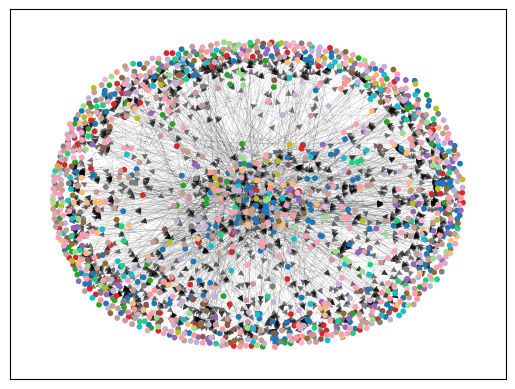

In [24]:
# Draw graph. Set color of nodes based on department
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos, edgelist=G.edges, arrows=True, width=0.1, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color=[G.nodes[n]['color'] for n in G.nodes])
plt.show()

# Analyse words in departments

Purpose:

We want to look at the common words/wordclouds for each partition. 

### Get stopwords

In [25]:
# Download stopwords if you haven't already
nltk.download('stopwords')

# Get the list of English stopwords from nltk
nltk_stopwords = set(stopwords.words("english"))

# Define your own custom stopwords
with open("stopwords.txt", "r") as file:
    custom_stopwords = {line.strip() for line in file}

# Combine nltk stopwords with your custom stopwords
stop_words = nltk_stopwords.union(custom_stopwords)

# Define a function to remove stopwords from text
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)


[nltk_data] Downloading package stopwords to /home/mp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### TF-IDF

### Departmentwise

In [26]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
    words = text.lower().split()
    # Remove stopwords
    cleaned_words = [word for word in words if word not in stop_words]
    return cleaned_words

# Populate color partitions with lists of words in each course description
color_partitions = defaultdict(list)
for node, data in G.nodes(data=True):
    color = data.get("color")  
    text = data.get("course_text")  
    
    if color and text:
        # Clean the course text and split into words
        cleaned_words = clean_text(text)
        color_partitions[color].append(cleaned_words)

# Map colors to department names using department_colors and department_names dictionaries
color_to_department = {}
for dept_code, color in department_colors.items():
    color_to_department[color] = department_names.get(dept_code, "Unknown Department")

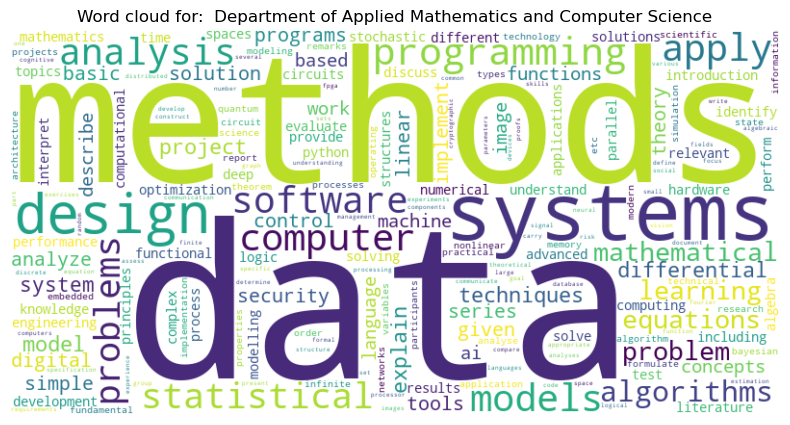

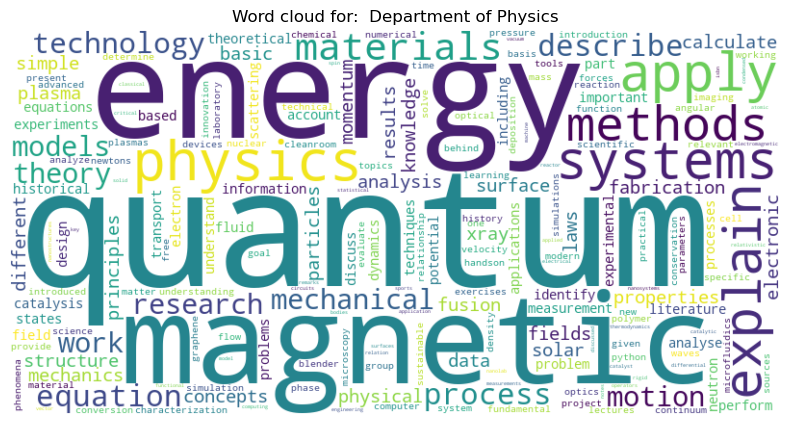

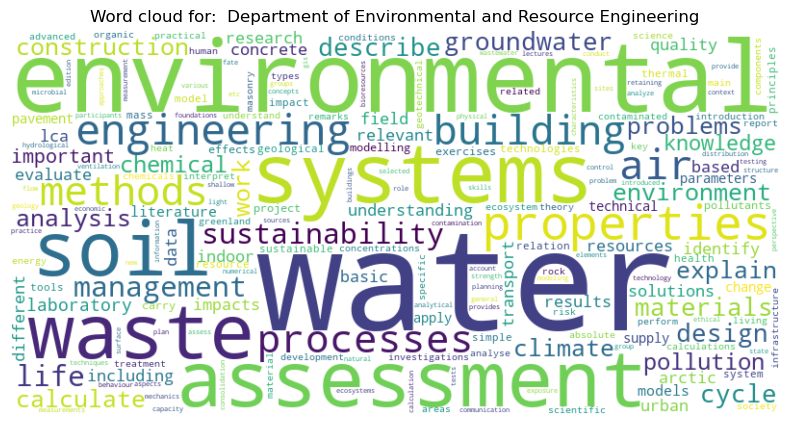

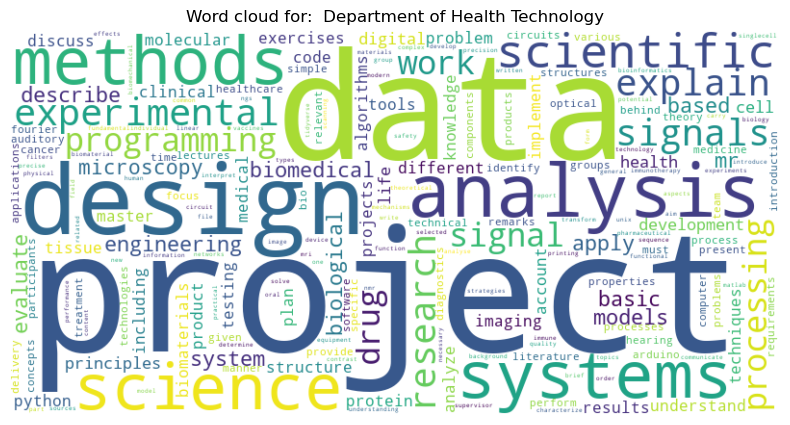

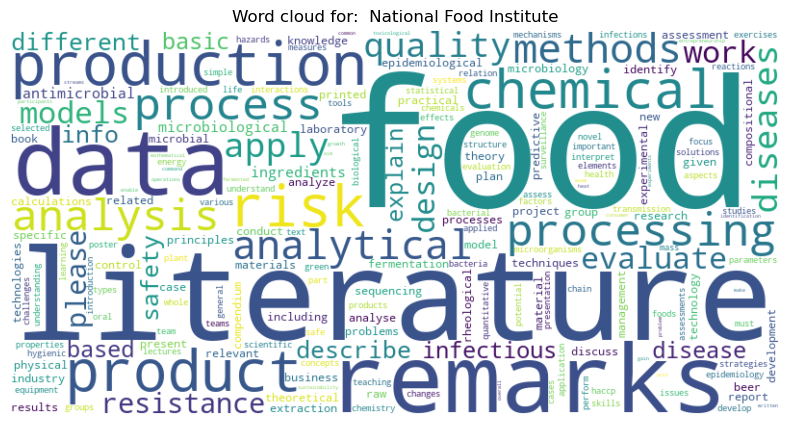

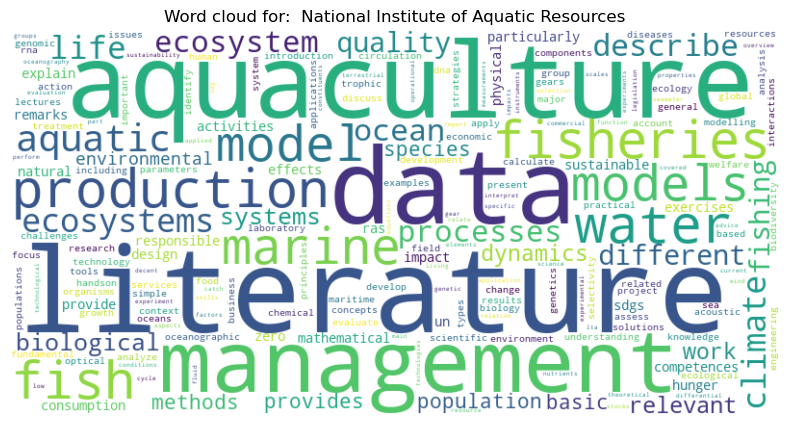

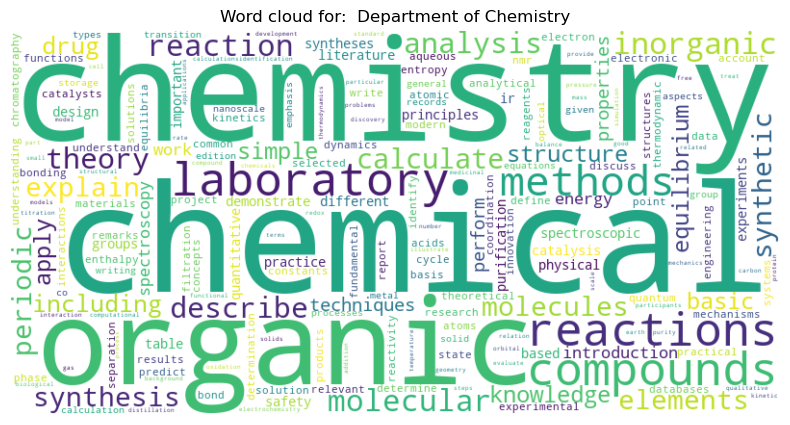

KeyboardInterrupt: 

In [27]:

# Generate word clouds for each color partition (in this case; department)
for color, documents in color_partitions.items():
    # Flatten list of lists into a single list of words for TF-IDF
    documents_flat = [' '.join(doc) for doc in documents]
    documents_flat = [doc for doc in documents_flat if doc]  # Remove empty documents

    # Calculate TF-IDF for the partition's documents using TfidfVectorizer
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents_flat)
    feature_names = vectorizer.get_feature_names_out()

    tfidf_scores = tfidf_matrix.sum(axis=0).A1  # Sum TF-IDF scores across all documents
    
    # Create a dictionary of terms and their aggregated TF-IDF scores
    aggregated_scores = dict(zip(feature_names, tfidf_scores))
    
    # Filter out terms with zero scores
    aggregated_scores = {term: score for term, score in aggregated_scores.items() if score > 0}

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(aggregated_scores)
    
    # Get department name for this color
    department_name = color_to_department.get(color, "Unknown Department")
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word cloud for:  {department_name}")
    plt.show()

# Analyse words in communities